# Figure 4

In [1]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.stats as stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
from pathlib import Path
from glob import glob
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

In [129]:
#full expression
def analytical_method3(glass_data, target_n):
    l_d = 0.37*glass_data['volume']**(1/3)
    W = glass_data['width']
    L = glass_data['length']
    volume_sensing = np.pi*((L-W)*(W+2*l_d)**2)/4 + np.pi*((W+2*l_d)**3)/6
    term1 = np.pi*(2*(W+2*l_d)**3 + 3*W*(W+2*l_d)**2 - W**3)/24
    term2 = ((L-W)*(W+2*l_d)**2)/4
    term3 = np.pi/2 + np.arcsin(W/(W + 2*l_d)) + (W*np.sqrt((W+2*l_d)**2-W**2))/(W+2*l_d)**2
    term = (term1 + term2*term3)/volume_sensing
    
    print(term)
    
    # Constants
    omega_p = 9  # plasma frequency in eV
    epsilon_inf = 9.84  # high-frequency dielectric constant
    n_glass = 1.52  # effective refractive index for glass substrate
    aspect_ratio = glass_data['ratio']  # given aspect ratio
    n_X = target_n  # refractive index for unknown substrate

    alpha = term
    n_med = 1.0
    n_eff_glass = alpha*n_med + (1-alpha)*n_glass
    n_eff_X = alpha*n_med + (1-alpha)*n_X

    # Depolarization factor L for the given aspect ratio
    L = (1 + aspect_ratio)**-1.6

    # Resonance energy for glass substrate
    E_res_glass = omega_p / np.sqrt(n_eff_glass**2 / L + epsilon_inf - n_eff_glass**2)

    # Resonance energy for unknown substrate
    E_res_X = omega_p / np.sqrt(n_eff_X**2 / L + epsilon_inf - n_eff_X**2)

    # Calculate the factor F
    F = E_res_X / E_res_glass
    
    return F

In [145]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all glass data
# glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
# glass_data['ratio'] = glass_data['length'] / glass_data['width']
# glass_data = glass_data.drop(['corrcoef'], axis=1)
# glass_data['volume'] = np.pi*(glass_data['width']**2)*glass_data['length']/4 - np.pi*(glass_data['width']**3)/12

glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data = glass_data.drop(['corrcoef'], axis=1)

original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
glass_data = pd.concat([glass_data, original_data], axis=0)
glass_data['volume'] = np.pi*(glass_data['width']**2)*glass_data['length']/4 - np.pi*(glass_data['width']**3)/12
glass_data['ratio'] = glass_data['length'] / glass_data['width']
glass_data = glass_data[(glass_data['width'] < 60) & (glass_data['length'] < 130)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

(1701, 7)


In [146]:
p = Path('C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/projects/AuNR_DA')
exp_data1 = pd.read_csv(Path(p, '080624_Zhenyang_exp_al2o3_1.csv'))
exp_data2 = pd.read_csv(Path(p, '080624_Zhenyang_exp_al2o3_2.csv'))
# convert str into list after reading csv
exp_data1['exp_ene'] = [ast.literal_eval(df) for df in exp_data1['exp_ene']]
exp_data1['exp_dfs'] = [ast.literal_eval(df) for df in exp_data1['exp_dfs']]
exp_data1['fitting'] = [ast.literal_eval(df) for df in exp_data1['fitting']]
exp_data2['exp_ene'] = [ast.literal_eval(df) for df in exp_data2['exp_ene']]
exp_data2['exp_dfs'] = [ast.literal_eval(df) for df in exp_data2['exp_dfs']]
exp_data2['fitting'] = [ast.literal_eval(df) for df in exp_data2['fitting']]
print(exp_data1.shape, exp_data2.shape)

exp_data = pd.concat([exp_data1, exp_data2], axis=0, ignore_index=True)
print(exp_data.shape)

(22, 11) (18, 11)
(40, 11)


22.3746225 77.475195
0.9423710800728617 5.054843251568053


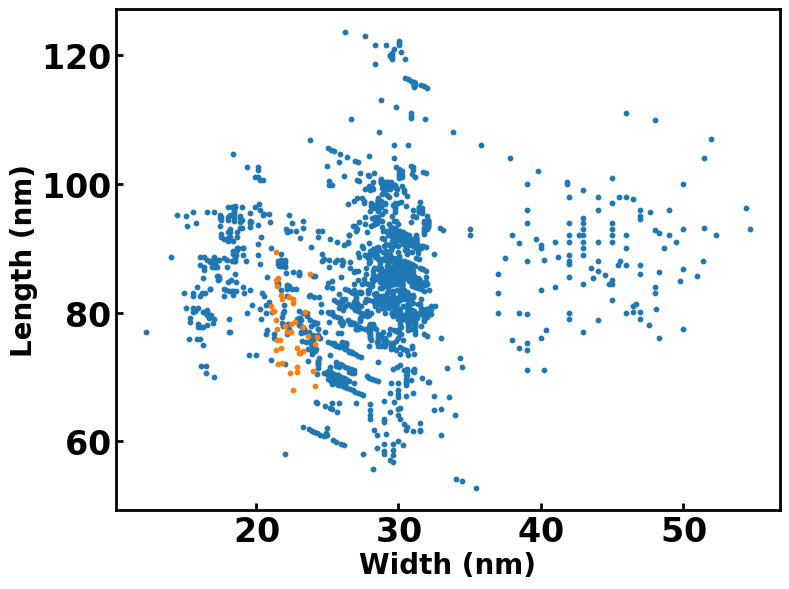

In [147]:
plt.scatter(glass_data['width'], glass_data['length'], s=10)
plt.scatter(exp_data['width'], exp_data['length'], s=10)
plt.xlabel('Width (nm)')
plt.ylabel('Length (nm)')
print(exp_data['width'].mean(), exp_data['length'].mean())
print(exp_data['width'].std(), exp_data['length'].std())

1.7456996862419865


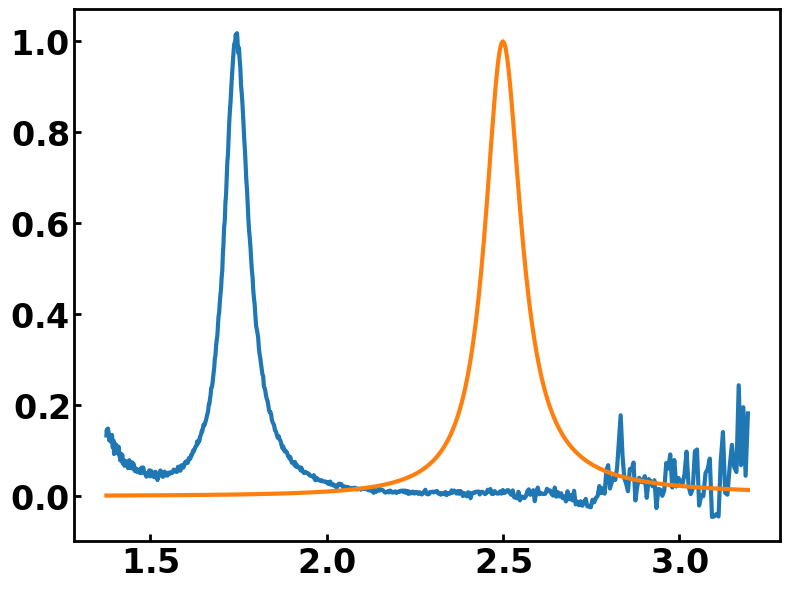

In [148]:
part_num = 9
plt.plot(exp_data['exp_ene'][part_num-1], [i / max(exp_data['fitting'][part_num-1]) for i in exp_data['exp_dfs'][part_num-1]])
plt.plot(exp_data['exp_ene'][part_num-1], [i / max(exp_data['fitting'][part_num-1]) for i in exp_data['fitting'][part_num-1]])
print(exp_data['eres'][part_num-1])

In [149]:
# tio2_data = tio2_data.sample(50, random_state=42)
X_al2o3 = exp_data.drop(['exp_ene', 'exp_dfs', 'fitting', 'imax', 'width', 'length', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
yw_al2o3 = exp_data['width']
yl_al2o3 = exp_data['length']
print(exp_data.shape)

(40, 11)


## analytical method

In [150]:
# glass_data = glass_data.sample(1500, random_state=42)
# define input and output
X_glass = glass_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = glass_data['width']
yl_glass = glass_data['length']

In [151]:
# parameters for GridSearchCV class
param_grid = {'max_depth': range(1, 21)}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred0 = gsw.predict(X_al2o3)

rel_errw0 = (abs(yw_al2o3-yw_pred0)/yw_al2o3)*100
rmspew0 = (sum(rel_errw0**2)/len(yw_pred0)) ** 0.5
maew0 = mean_absolute_error(yw_al2o3, yw_pred0)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred0 = gsl.predict(X_al2o3)

rel_errl0 = (abs(yl_al2o3-yl_pred0)/yl_al2o3)*100
rmspel0 = (sum(rel_errl0**2)/len(yl_pred0)) ** 0.5
mael0 = mean_absolute_error(yl_al2o3, yl_pred0)

print(rmspew0, rmspel0)
print(maew0, mael0)

14.797681484717417 10.339847434012489
2.7980613987825906 5.660004237455705


In [152]:
F_Al2O3 = analytical_method3(glass_data, target_n=1.762)
X_glass['eres'] = X_glass['eres']*F_Al2O3

0       0.845384
1       0.820900
2       0.826646
3       0.814040
4       0.832690
          ...   
1696    0.802583
1697    0.797095
1698    0.809652
1699    0.809756
1700    0.792868
Length: 1701, dtype: float64


In [153]:
# parameters for GridSearchCV class
param_grid = {'max_depth': range(1, 21)}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred1 = gsw.predict(X_al2o3)

rel_errw1 = (abs(yw_al2o3-yw_pred1)/yw_al2o3)*100
rmspew1 = (sum(rel_errw1**2)/len(yw_pred1)) ** 0.5
maew1 = mean_absolute_error(yw_al2o3, yw_pred1)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred1 = gsl.predict(X_al2o3)

rel_errl1 = (abs(yl_al2o3-yl_pred1)/yl_al2o3)*100
rmspel1 = (sum(rel_errl1**2)/len(yl_pred1)) ** 0.5
mael1 = mean_absolute_error(yl_al2o3, yl_pred1)

print(rmspew1, rmspel1)
print(maew1, mael1)

15.64540106481875 8.520803443374435
3.1203476007326016 4.2187255048234835


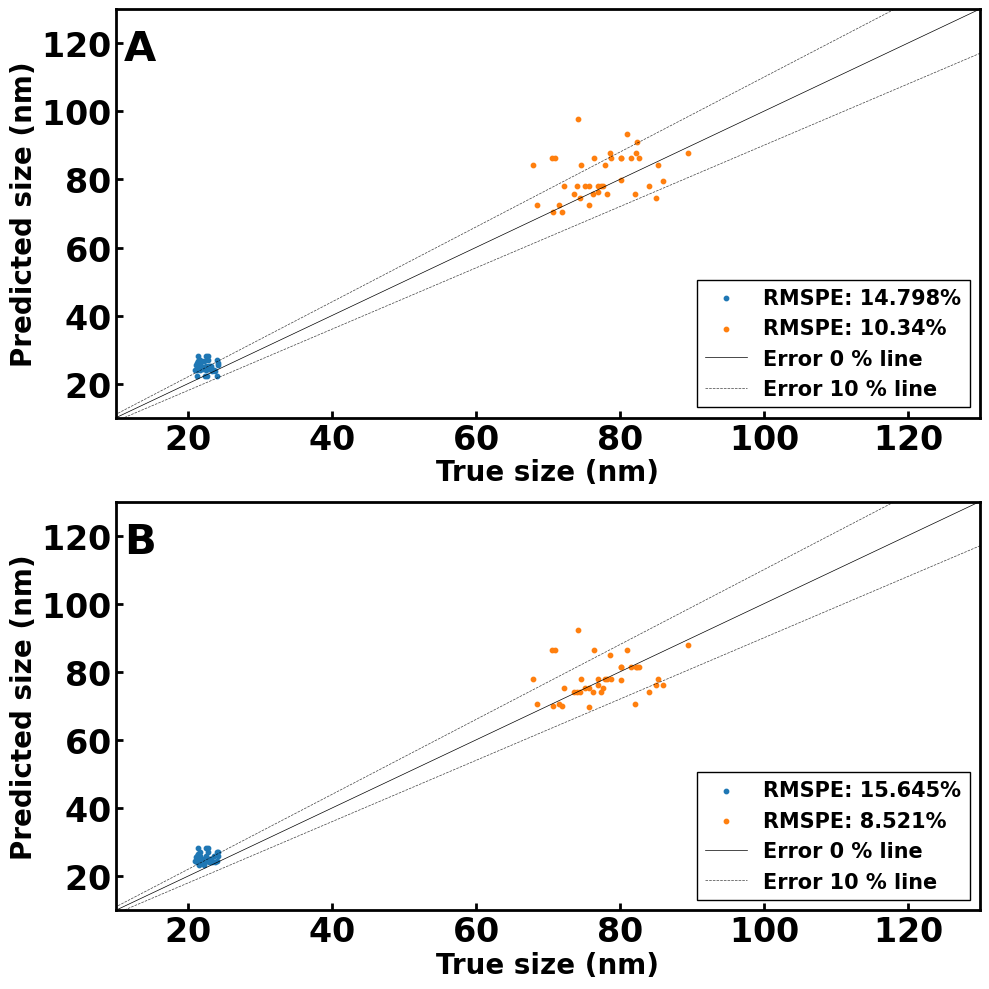

In [154]:
# Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(10, 10))

ax1.scatter(yw_al2o3, yw_pred0, s=10, label=f'RMSPE: {round(rmspew0, 3)}%')
ax1.scatter(yl_al2o3, yl_pred0, s=10, label=f'RMSPE: {round(rmspel0, 3)}%')

x = np.arange(-1, 181)
ax1.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax1.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax1.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax1.set_xlabel('True size (nm)')
ax1.set_ylabel('Predicted size (nm)')
# ax1.set_xticks([2.5, 3.0, 3.5, 4.0, 4.5])
# ax1.set_yticks([1.5, 1.7, 1.9])
ax1.set_xlim(10, 130)
ax1.set_ylim(10, 130)
ax1.legend(loc='lower right', fontsize=15)
ax1.text(0.01, 0.95, 'A', ha='left', va='top', transform=ax1.transAxes, fontsize=30)

ax2.scatter(yw_al2o3, yw_pred1, s=10, label=f'RMSPE: {round(rmspew1, 3)}%')
ax2.scatter(yl_al2o3, yl_pred1, s=10, label=f'RMSPE: {round(rmspel1, 3)}%')

x = np.arange(-1, 181)
ax2.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax2.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax2.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax2.set_xlabel('True size (nm)')
ax2.set_ylabel('Predicted size (nm)')
# ax2.set_xticks([2.5, 3.0, 3.5, 4.0, 4.5])
# ax2.set_yticks([1.5, 1.7, 1.9])
ax2.set_xlim(10, 130)
ax2.set_ylim(10, 130)
ax2.legend(loc='lower right', fontsize=15)
ax2.text(0.01, 0.95, 'B', ha='left', va='top', transform=ax2.transAxes, fontsize=30)

plt.subplots_adjust(hspace=0)  # Remove the space between plots